# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from tree import DTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
import pprint
import matplotlib.pyplot as plt

# Dataset

In [2]:
df = pd.read_csv('titanic.csv') # Read titanic dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
#simple preprocessing
df['Age'].fillna(df['Age'].mean(), inplace = True)  # Replace with average
df['Embarked'].fillna('N', inplace = True)          # Replace with 'N'
df['Sex'] = df['Sex'].factorize()[0]                # label encoding
df['Embarked'] = df['Embarked'].factorize()[0]      # label encoding
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [5]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13.0000,0
887,1,1,1,19.000000,0,0,30.0000,0
888,0,3,1,29.699118,1,2,23.4500,0
889,1,1,0,26.000000,0,0,30.0000,1


In [6]:
# split the data into train and test data.
y = np.array(df['Survived'])
x = np.array(df.drop('Survived', axis=1))
x_train, x_test, y_train, y_test = train_test_split(x, y)

# Binary Classification Testing (DTreeClassifier vs sklearn)

In [7]:
depth = 1
my_model = DTreeClassifier(max_depth = depth)
my_model.fit(x_train, y_train)
my_pred = my_model.predict(x_test)
acc = (y_test == my_pred).mean()
print('MyTreeClassifier: accuracy = {:.3f}'.format(acc))

MyTreeClassifier: accuracy = 0.780


DecisionTreeClassifier: accuracy = 0.780

MyTreeClassifier: estimator2:
{'is_leaf': False,
 'fid': 1,
 'split_point': 0.5,
 'left_child': 0,
 'right_child': 1}


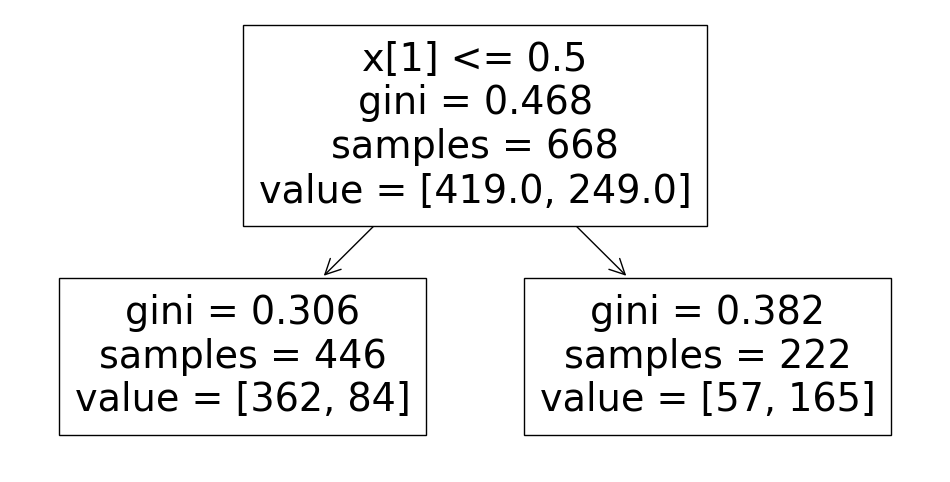

In [8]:
# Compare the results with sklearn's DecisionTreeClassifier.
# ----------------------------------------------------------
sk_model = DecisionTreeClassifier(max_depth=depth, 
                                  random_state=1)
sk_model.fit(x_train, y_train)
sk_pred = sk_model.predict(x_test)
acc = (y_test == sk_pred).mean()
print('DecisionTreeClassifier: accuracy = {:.3f}'.format(acc))

print('\nMyTreeClassifier: estimator2:')
pprint.pprint(my_model.estimator2, sort_dicts=False)

plt.figure(figsize=(12, 6))
tree.plot_tree(sk_model)
plt.show()

# Analyse the importance of features

In [33]:
# Train model
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(x_train[:,[0,1,2]],y_train)

DecisionTreeClassifier(max_depth=3)

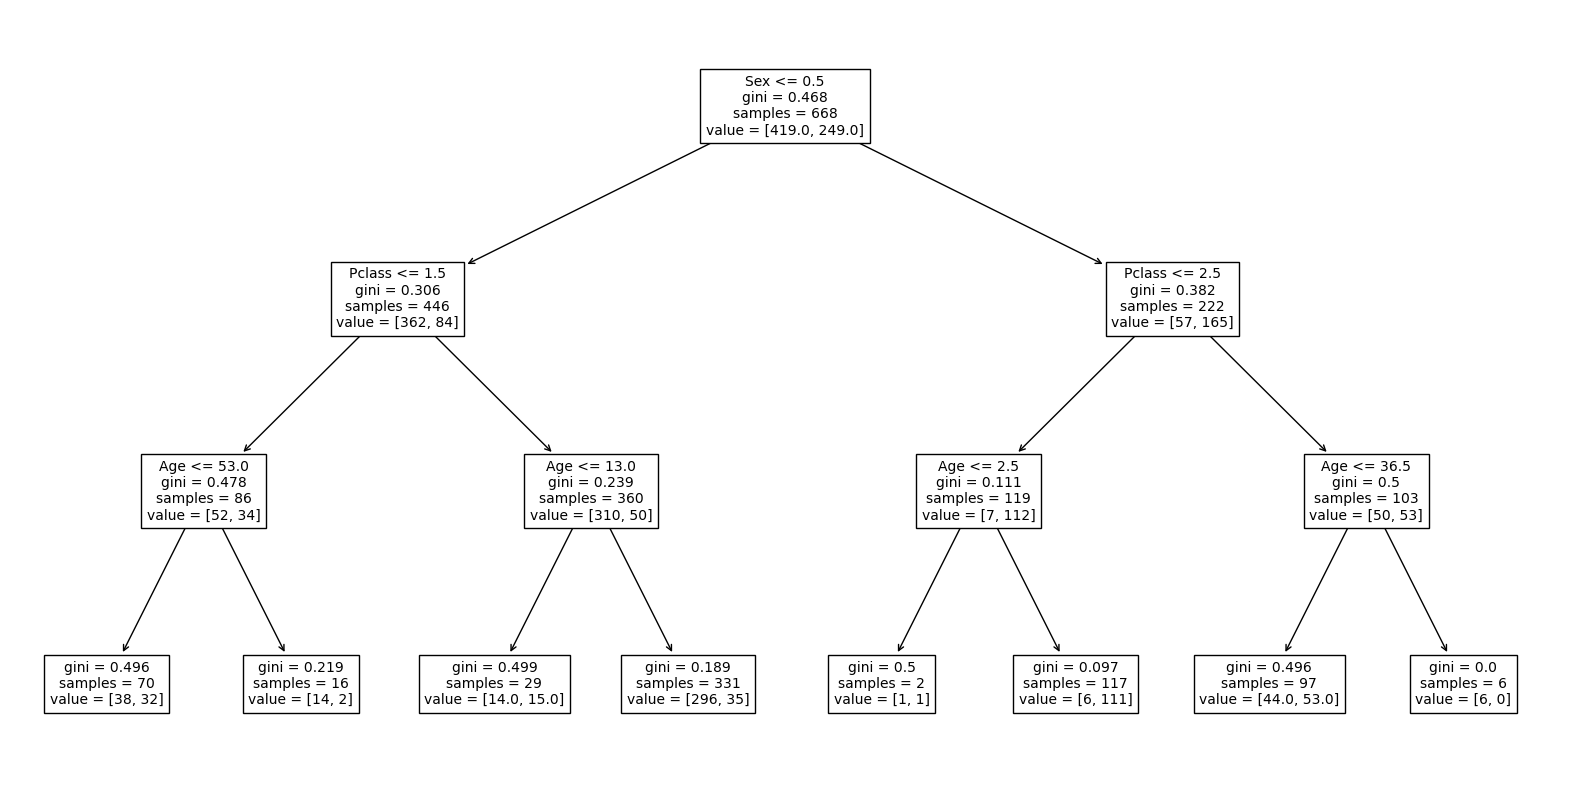

In [34]:
# Visualize the tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=['Pclass','Sex','Age'], fontsize=10)
plt.show()

In [35]:
# Analyse the importance of features
feature_importance = clf.feature_importances_
n_feature = 3
idx = np.arange(n_feature)

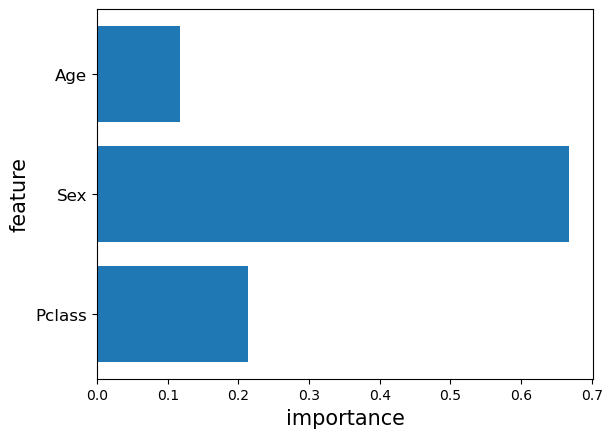

In [36]:
plt.barh(idx,feature_importance,align='center')
plt.yticks(idx,['Pclass','Sex','Age'],size=12)
plt.xlabel('importance',size=15)
plt.ylabel('feature',size=15)
plt.show()

In [41]:
feature_importance

array([0.21400546, 0.66833758, 0.11765696])

# Cost Complexity Pruning

In [42]:
# Apply Cost Complexity Pruning and get the alpha-star list
dt = DecisionTreeClassifier()
path = dt.cost_complexity_pruning_path(x_train,y_train)

In [44]:
ccp_alpha=path.ccp_alphas[:-1]
impurity=path.impurities[:-1]

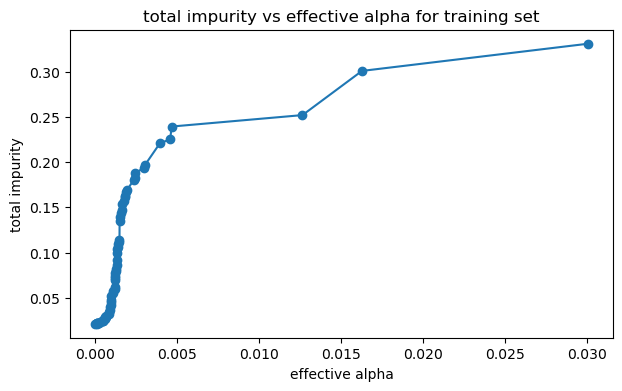

In [46]:
# observe impurity changes as alpha changes
# As alpha increases the penalty |T| increases, resulting
# in simple trees and increased impurity (misclassification error)
plt.figure(figsize=(7,4))
plt.plot(ccp_alpha,impurity,marker='o')
plt.xlabel('effective alpha')
plt.ylabel('total impurity')
plt.title('total impurity vs effective alpha for training set')
plt.show()

In [48]:
# Create trees for each alpha in the alpha-list
models=[]
for alpha in ccp_alpha:
    model=DecisionTreeClassifier(ccp_alpha=alpha)
    model.fit(x_train,y_train)
    models.append(model)

In [49]:
# node count and depth vs alpha
node_counts=[model.tree_.node_count for model in models]
depth=[model.tree_.max_depth for model in models]

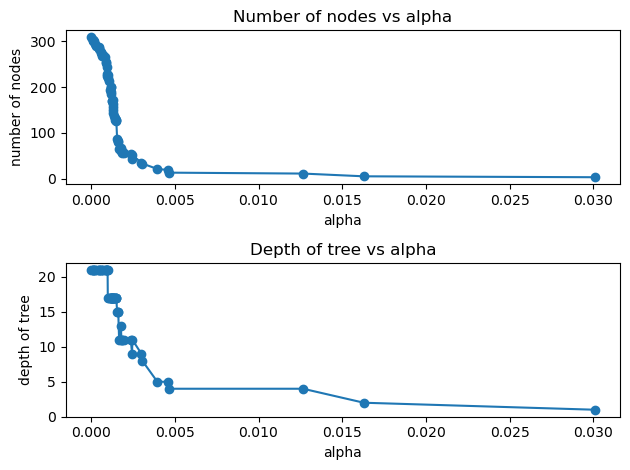

In [54]:
fig, ax = plt.subplots(2,1)
ax[0].plot(ccp_alpha,node_counts,marker='o')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of nodes')
ax[0].set_title('Number of nodes vs alpha')
ax[1].plot(ccp_alpha,depth,marker='o')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('depth of tree')
ax[1].set_title('Depth of tree vs alpha')
fig.tight_layout()